Comparison of `Log-Linear Poission Regression` with a linear model fitted with least square error, and non-linear GBRT model with Poisson Loss

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml 

df = fetch_openml(data_id = 41214, as_frame=True, parser="pandas").frame 
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


Log-linear poisson 
- frequency `y = ClaimNb / Exposure` 

Average Frquency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


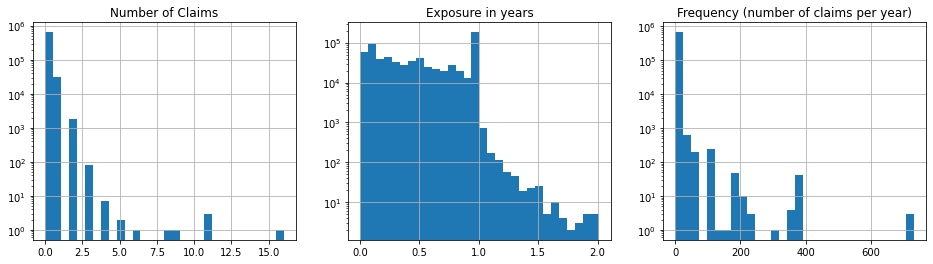

In [3]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Average Frquency = {}".format(np.average(df["Frequency"], weights=df["Exposure"])))
print("Fraction of exposure with zero claims = {0:.1%}".format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()))


fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,4))
ax0.set_title("Number of Claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)


Performing standard feature transformation on the remaining columns that can be used to predict the frequenct of claim events 

In [4]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder 
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer 
from sklearn.compose import ColumnTransformer 

In [5]:
log_scaler_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())
linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge","DrivAge"],
        ),
        ("log_scaled_numeric",log_scaler_transformer, ["Density"]),
        ("onehot_categorical", OneHotEncoder(), ["VehBrand", "VehPower","Region","Area"],),
    ], remainder="drop"
)

Building a baseline "dummy" estimator that constantly predicts the mean frequency of the training sample

In [6]:
from sklearn.dummy import DummyRegressor 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split 

In [7]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)
dummy = Pipeline(
    [("preprocessor", linear_model_preprocessor), ("regressor", DummyRegressor(strategy="mean"))]
).fit(df_train, df_train["Frequency"], regressor__sample_weight= df_train["Exposure"])

computing the performance of this constant prediction baseline with 3 different regression metrics 

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance

In [9]:
def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f"
        % mean_squared_error(df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]))
    print("MAE: %.3f"
        % mean_absolute_error(df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print("WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance.")
    print("mean Poisson deviance: %.3f"
        % mean_poisson_deviance(df_test["Frequency"][mask], y_pred[mask], sample_weight=df_test["Exposure"][mask]))


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


Linear Models with least square error (ridge regression)

In [10]:
from sklearn.linear_model import Ridge 

ridge_glm = Pipeline(
    [("preprocessor", linear_model_preprocessor),("regressor", Ridge(alpha=1e-6))]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [11]:
print("Ridge Evaluation: ")
score_estimator(ridge_glm, df_test)

Ridge Evaluation: 
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.596


`Poissor Regressor` modelling
- `Poisson regressor` models the log of the expected target value instead of expected value directly, the relationship between X and y is not linear anymore - that's why name - `Generalized Linear Model`

In [12]:
from sklearn.linear_model import PoissonRegressor 
n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [("preprocessor", linear_model_preprocessor), ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky"))]
)
poisson_glm.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10,
                                                                   random_state=0,
                                                                   subsample=200000),
                                                  ['VehAge', 'DrivAge']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Density']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'Region', 'Area'])])),
                ('regressor',
                 PoissonRegressor(alpha=1e-12, solver='newton-cholesky'))])

In [13]:
print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


Gradient Boosting Regression Trees for Poissn Regression
- Gradient Boosting also gives the possibility to fit the trees with a Poisson loss (with an implicit log-link function) instead of the default least-squares loss.

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.preprocessing import OrdinalEncoder 

In [15]:
tree_preprocessor = ColumnTransformer(
    [
    ("categorical", OrdinalEncoder(),["VehBrand","VehPower", "VehGas","Region","Area"]),
    ("numeric", "passthrough",["VehAge","DrivAge","BonusMalus","Density"]),], remainder="drop"
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        ("regressor",HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),)]
)
poisson_gbrt.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.565
MAE: 0.184
mean Poisson deviance: 0.575


#Visualization of models

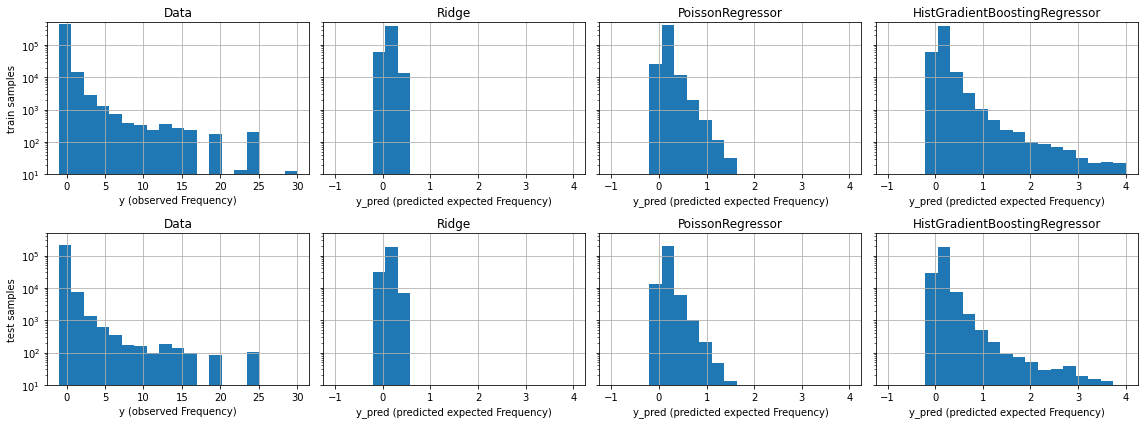

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

 `PoissonRegressor` and `HistGradientBoostingRegressor` are a-priori better suited for modeling the long tail distribution of the non-negative data as compared to the `Ridge` model which makes a wrong assumption on the distribution of the target variable.

To ensure that estimators yield reasonable predictions for different policyholder types, we can bin test samples according to y_pred returned by each model. Then for each bin, we compare the mean predicted y_pred, with the mean observed target:

In [17]:
from sklearn.utils import gen_even_slices

Actual number of claims: 11935
Predicted number of claims by Ridge(alpha=1e-06): 11933.8
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 11931.7
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12184.4
Predicted number of claims by DummyRegressor(): 11931.2


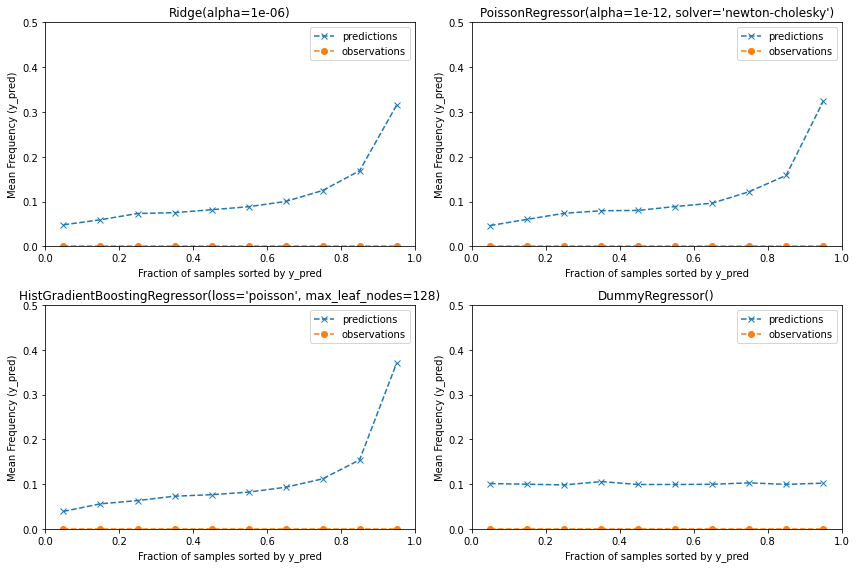

In [18]:
def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins = 100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0,1,1 / n_bins) + 0.5 / n_bins 
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_pred_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values 
    exposure = df_test["Exposure"].values 
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=exposure, n_bins=10)

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()



Measuring ability of the model to rank the riskiest from the safest policyholders, irrespective of the absolute value of the prediction can be done by plotting the cumulative proportion of claims vs the cumulative proportion of exposure for the test samples order by the model predictions

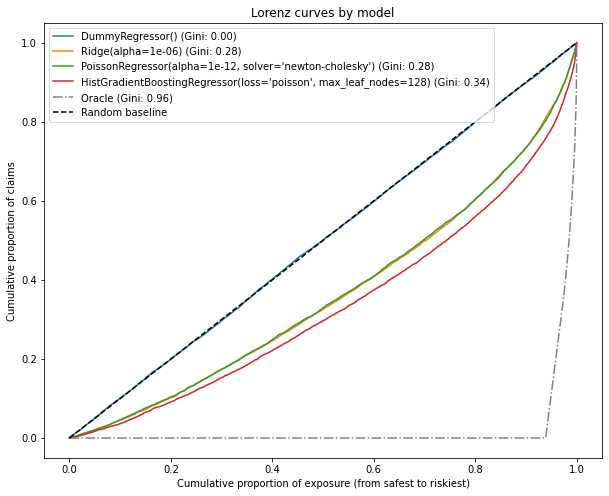

In [24]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(10, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(df_test["Frequency"], y_pred, df_test["Exposure"])
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(df_test["Frequency"], df_test["Frequency"], df_test["Exposure"])
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(title="Lorenz curves by model", xlabel="Cumulative proportion of exposure (from safest to riskiest)",
       ylabel="Cumulative proportion of claims")
ax.legend(loc="upper left")